## Basics of Tensorflow

This shows the main ideas behind the Tensorflow package. 
Lets first import tensorflow and numpy.

In [1]:
import numpy as np
import tensorflow as tf

Tensorflow enables us to express a computation graph. As a simple example, lets consider the function: 
 `y = x^2 + 2*x + 1`

We start with defining a variable for the input of the function, x. We tell Tensorflow to allocate a placeholder for the input of size 1 and type float32:

In [3]:
x = tf.placeholder(tf.float32, shape=(1))
print x

Tensor("Placeholder_1:0", shape=(1,), dtype=float32)


Next, we can write the expression for y as follows:

In [5]:
y = x**2 + 2*x + 1
print y

Tensor("add_3:0", shape=(1,), dtype=float32)


Lets see how to run this. To evaluate y we need to specify a value for x and then run the (very simple, in our case) computation graph. To do this in tensorflow, we need to create a session object, and use its run method. Let us first create a session.

In [7]:
sess = tf.InteractiveSession()

Now that we have a session, we can use its run method. The sess.run command recieves the tensorflow object we'd like to compute, in our case y. Since y depends on x, which is just a placeholder, we need to tell tensorflow to assign a specific value to x. This is done by creating a dictionary with entries of the form {tensorflow_placeholder_object: numpy_array}. 

In [8]:
actual_value_for_x = np.array([5],dtype=np.float32)
computed_y = sess.run(y, feed_dict={x:actual_value_for_x})
print 'x was assigned to %f, so y = %f' % (actual_value_for_x,computed_y)

x was assigned to 5.000000, so y = 36.000000


### let's see the graph:

In [10]:
writer = tf.summary.FileWriter('/tmp/Basics/', sess.graph)
writer.flush()

The output of sess.run is a numpy array, so we can repeat the above in a loop. Just as a simple stupid example:

In [11]:
for val in range(-2,3):
    computed_y = sess.run(y, feed_dict={x:np.array([val],dtype=np.float32)})
    print "x = %f,   y = %f" % (val, computed_y)

x = -2.000000,   y = 1.000000
x = -1.000000,   y = 0.000000
x = 0.000000,   y = 1.000000
x = 1.000000,   y = 4.000000
x = 2.000000,   y = 9.000000


A more efficient way is to perform the operations on tensors. 

In [13]:
X = tf.placeholder(tf.float32, shape=(None))
Y = tf.pow(X, 2.0) + 2*X + 1
val = np.array(range(-2,3),dtype=np.float32)
computed_Y = sess.run(Y, feed_dict={X: val})
print 'X = ', val
print 'Y = ', computed_Y
print ''
val = np.array(range(10),dtype=np.float32)
computed_Y = sess.run(Y, feed_dict={X: val})
print 'X = ', val
print 'Y = ', computed_Y

X =  [-2. -1.  0.  1.  2.]
Y =  [ 1.  0.  1.  4.  9.]

X =  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
Y =  [   1.    4.    9.   16.   25.   36.   49.   64.   81.  100.]


Note that we have defined the shape of X as None. In such a case, the computation graph should support variable-size tensors. The actual value is determined only when we feed a specific numpy array as the value of the placeholder X.

## Backward and Gradients

We saw how Tensorflow implements a forward pass using sess.run. We can calculate the derivative (Jacobian) of a variable w.r.t. another variable. To do so, we use the command tf.gradients which receives a variable (say, Y) and calculate the derivative w.r.t. all the variables in the list of its second argument. The code below demonstrates it:

In [15]:
G = tf.gradients(Y,X)
val = np.array(range(-2,3),dtype=np.float32)
computed_Y, computed_G = sess.run([Y,G],feed_dict={X: val})
print "X =                  ", val
print "Y = X**2 + 2*X + 1 = ", computed_Y
print "G =  2*X +  2      = ", computed_G[0]

X =                   [-2. -1.  0.  1.  2.]
Y = X**2 + 2*X + 1 =  [ 1.  0.  1.  4.  9.]
G =  2*X +  2      =  [-2.  0.  2.  4.  6.]


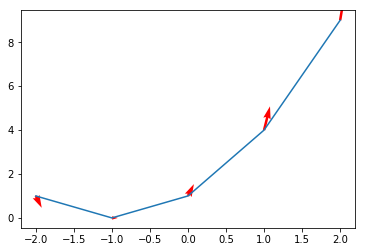

In [16]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(val, computed_Y)
plt.quiver(val, computed_Y, [1]*5, computed_G, color='r')
plt.show()

## A simple SGD implementation

O.k., so now that we know to construct graphs and calculate gradients, we can have a very simple implementaiton of Stochatic Gradient Descent. We'll first construct synthetic data.

In [18]:
true_model = np.random.randn(10,1)

data = np.random.uniform(low=0.0, high=1.0, size=(1000,10))
true_labels = np.matmul(data,true_model)
print data[0]
print true_labels[0]

[ 0.80650229  0.15118908  0.13082003  0.31527363  0.3642126   0.53184358
  0.62729629  0.96517319  0.07973055  0.86025677]
[-0.56420157]


We'll construct a computation graph that takes a minibatch of 10 examples, multiply them by weights to get predictions, and feed this together with the corresponding true_labels to a hinge-loss function 

In [19]:
with tf.name_scope('SGD'):
    data_placeholder = tf.placeholder(tf.float32, 
                                      shape=(None,data.shape[1]), 
                                      name='data')
    label_placeholder = tf.placeholder(tf.float32, 
                                       shape=(None,1), name='labels')
    weights_placeholder = tf.placeholder(tf.float32, 
                                         shape=(data.shape[1],1), 
                                         name='weights')
    predict = tf.matmul(data_placeholder, weights_placeholder, 
                        name='predict')
    loss = tf.reduce_mean(tf.pow(label_placeholder - predict,2.0), 
                          name='loss')
    grad = tf.gradients(loss,[weights_placeholder])[0]

### let's see the graph:

In [20]:
writer = tf.summary.FileWriter('/tmp/Basics/', sess.graph)
writer.flush()

Now that we've constructed the graph we can write a code for SGD

In [21]:
batchsize = 10
T = 1000
eta = 0.1
w = np.random.randn(10,1)
allW=[w]
for _ in range(T):
    I = np.random.randint(0,high=data.shape[0],size=(batchsize))
    g = sess.run(grad, feed_dict={data_placeholder:data[I,:], 
                                  label_placeholder:true_labels[I], 
                                  weights_placeholder:w})
    w = w - eta*g
    allW.append(w)

allW=np.hstack(allW)

In [23]:
print "w = ", w.T
print "true_model = ", true_model.T
print "w-true_model = ", w.T-true_model.T
print "|w-true_model|=", np.linalg.norm(w-true_model)

w =  [[-0.37354857 -0.1353558  -1.94126904 -1.43569549 -1.41039444  0.62120335
   1.77329733 -0.07416898 -0.03657531 -0.45388301]]
true_model =  [[-0.37354814 -0.13535586 -1.9412691  -1.4356958  -1.41039458  0.62120349
   1.7732972  -0.07416898 -0.03657494 -0.45388333]]
w-true_model =  [[ -4.26863636e-07   5.78351849e-08   5.67511287e-08   3.14485441e-07
    1.42974910e-07  -1.45008873e-07   1.34835957e-07   7.13268193e-09
   -3.76399539e-07   3.14836404e-07]]
|w-true_model|= 7.66928183168e-07


# Let's have a look at the convergence:

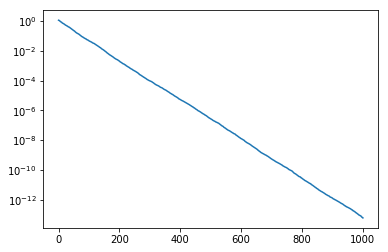

In [26]:
err = np.mean(np.power(true_model - allW, 2.0), axis=0)
plt.semilogy(err)
plt.show()

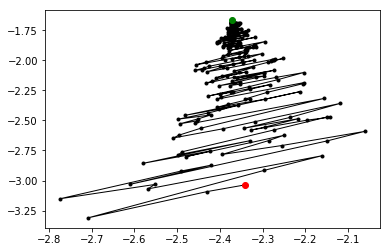

In [31]:
proj = np.random.rand(2,10)
p=np.matmul(proj, allW)
plt.clf()
plt.plot(p[0], p[1], 'k.-', linewidth=1)
plt.plot(p[0][0], p[1][0], 'ro')
plt.plot(p[0][-1], p[1][-1], 'go')
plt.show()

Tensorflow have additional components to make training easier. Below, we define the weights as a tf.Variable, we tell Tensorflow to initialize it, and we define a gradient descent optimizer.  

In [32]:
def optimize(T, eta):
    data_placeholder = tf.placeholder(tf.float32, 
                                      shape=(None,data.shape[1]))
    label_placeholder = tf.placeholder(tf.float32, shape=(None,1))
    weights = tf.Variable(tf.truncated_normal([data.shape[1], 1], 
                                              stddev=1.0 / np.sqrt(float(data.shape[1]))))
    predict = tf.matmul(data_placeholder, weights)
    loss = tf.reduce_mean(tf.pow(label_placeholder - predict,2.0))
    
    optimizer = tf.train.GradientDescentOptimizer(eta)
    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    
    sess.run(init)
    allW=[]
    for _ in range(T):
        I = np.random.randint(0,high=data.shape[0],size=(batchsize))
        _, w = sess.run([train_op, weights],
                        feed_dict={data_placeholder:data[I,:], 
                                   label_placeholder:true_labels[I]})
        allW.append(w)
    w = sess.run(weights)
    err = np.mean(np.power(true_model - w, 2.0))
    print 'Reached error of', err
    return np.hstack(allW)

In [33]:
def show(allW):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    #err = np.sqrt(np.sum(np.power(true_model - allW, 2),axis=0))
    err = np.mean(np.power(true_model - allW, 2.0), axis=0)
    ax1.semilogy(err)
    plt.title('Error')
    
    p=np.matmul(proj, allW)
    ax2.plot(p[0], p[1], 'k.-', linewidth=0.5)
    ax2.plot(p[0][0], p[1][0], 'ro')
    plt.title('Convergence')
    
    ws = np.matmul(proj, true_model)
    ax2.plot(ws[0], ws[1], 'g*')    # Show the solution
    plt.show()

Reached error of 0.0340296589038


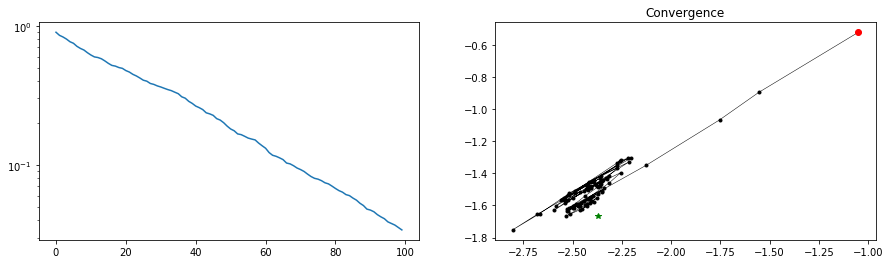

In [34]:
show(optimize(100, 0.1))

So 100 iterations are not enough

Reached error of 1.28934827711e-13


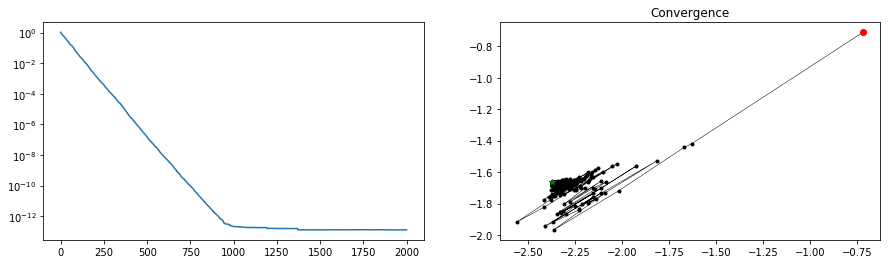

In [36]:
allW=optimize(2000, 0.1)
show(allW)

Let's zoom into the last iterations:

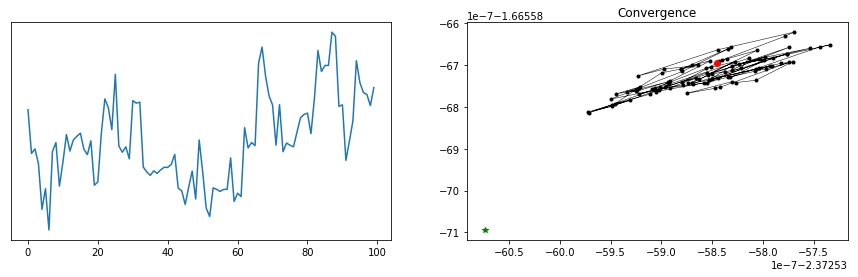

In [37]:
show(allW[:,-100:])

That's it for the basics. If you reached here, you should know how Tensorflow perform forward and backward on a computation graph, and you should also be familiar with tf.Variable and optimizers.